# An Evaluation of Time Series Anomaly Detection Using Keras
## Jon Ishaque G00398244
## Machine Learning and Statistics
## HDip in Computing with Data Analytics
## Atlantic Technical University

***

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In [1]:
#Numerical arrays and functions
import numpy as np

#Spreadsheet-like Data Frames
import pandas as pd

#Creating Neural Networks
import tensorflow.keras as keras

#layers of neural networks?
from tensorflow.keras import layers
#Python plotting library
from matplotlib import pyplot as plt

## Data

***

https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

#also shows best methods for datasets
what is standard profile
reward low fp
rewand low fn?

"Anomaly detection addresses the problem of identifying points and/or patterns that do not conform to an expected sense of normality in a dataset". (Singh and Olinsky, 2017)
This evaluation will us the Numenta Anomaly Benchmark(NAB) dataset. The datasets contains labelled anomolous periods of behaviour with both artificial and real data to enable anomaly detection benchmarking. That is to say, these datasets can be used to calibrate anomaly detection algorithms. This demonstration will use the __art_daily_small_noise__ dataset and the __art_daily_jumpsup__ data set. The art indicates this is artificial data and the daily that we are looking the time series is data over one day and the timestamp indicates 5 minute intervals. Small noise suggest that some background noise has been added. Jumps up suggests the anomaly!

In [2]:
# Get the root URL for ease of handling and to ease presentation
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

#Create the url for the data file without anomaly.

no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

#Create the url for the data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

In [5]:
# read in small noise no anomally into a PD dataframe
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [6]:
# display top of small noise data set
df_small_noise.head()


,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


Describe the  small noise 

samples are taken every 5 minutes

24 * 60/5 = 288 samples per day

288 * 14 day period 

 = 4032 samples

In [7]:

df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [8]:
# look at first row of small noise dataframe
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

In [9]:
# get value at first row of small noise dataframe
df_small_noise.iloc[0]['value']

18.3249185392

In [10]:
# get the first value of values at row 1
df_small_noise.iloc[0].values[0]

18.3249185392

In [11]:
# multiply by a trillion (why?)
df_small_noise.iloc[0].values[0] * 10e12

183249185392000.0

Shape of small noise dataframe is 4032 rows by 2 columns

In [12]:
# see shape of data frame

df_small_noise.shape

(4032, 1)

Visualising the small noise data set (no anomaly)
The 14 day time series shows (temperature data) at 5 minute intervals. The values increase at around 9.00am each day and fall off around 6.00pm each day. And indeed there is no visual anomaly
This will be the training dataset.

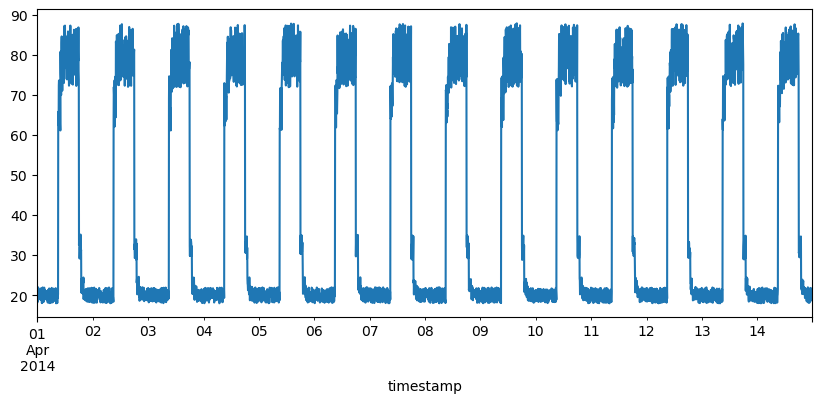

In [13]:
# use plt to make the plot size
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot small noise data frame (no anomalies).

df_small_noise.plot(legend=False, ax=ax); #semi colon hides return value!

In [14]:
#read in daily_jumps up data set into a PANDAS data frame
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [15]:
# displate the top 5 rows of the daily_jumps dataset
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


Like the small noise dataset
samples are taken every 5 minutes

24 * 60/5 = 288 samples per day

288 * 14 day period

= 4032 samples

note the max value in this data set is 164.947481, amost 4 times the mean

In [16]:

df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [17]:
# look at first row of daily jump dataframe
df_daily_jumpsup.iloc[0]

value    19.761252
Name: 2014-04-01 00:00:00, dtype: float64

In [18]:
# # get value at first row of daily jump dataframe
df_daily_jumpsup.iloc[0]['value']

19.761251903

Shape of daily jump set is 4032 rows by 2 columns

In [19]:
# look at shape of daily jump data set 
df_daily_jumpsup.shape

(4032, 1)

Visualising the daily jump data set. The 14 day time series shows (temperature data) at 5 minute intervals. The values increase at around 9.00am each day and fall off around 6.00pm each day. Visually, there is clear an anomoly on day 11 in the daytime

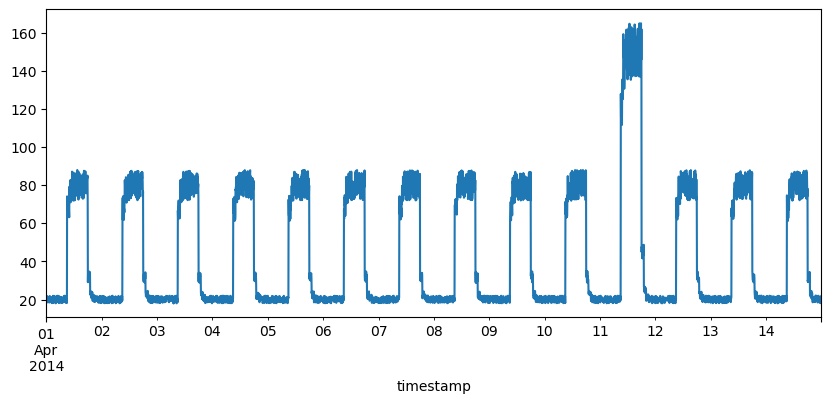

In [20]:
# use plt to visualise the dataset 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

## Preprocessing
why are we preprocessing???
***

In [21]:
# get the mean value from the small noise/training dataset
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [22]:
# get the standard deviation for the small noise/training data set
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

Prepare training data, get data values from the training timeseries data file and normalize the value data.
subtract by the mean training value and divide by the training standard deviation. This is 

https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff#:~:text=Normalization%20is%20useful%20when%20your,Gaussian%20(bell%20curve)%20distribution.

In [23]:
# subtract by mean of values and div by mean mean to centre on zero. scale down by bringing all scales between -.5 and 1.5
#


df_train_vals = (df_small_noise - train_mean) / train_std

In [77]:
# shape now 4032 rows by 4 cols
df_train_vals.shape
df_train_vals.iloc[0]
display(df_train_vals)

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640


In [76]:
# add less mean col
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
#add div by std col 
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [26]:
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [27]:
#get mean less mean, and mean div of std
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [28]:
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

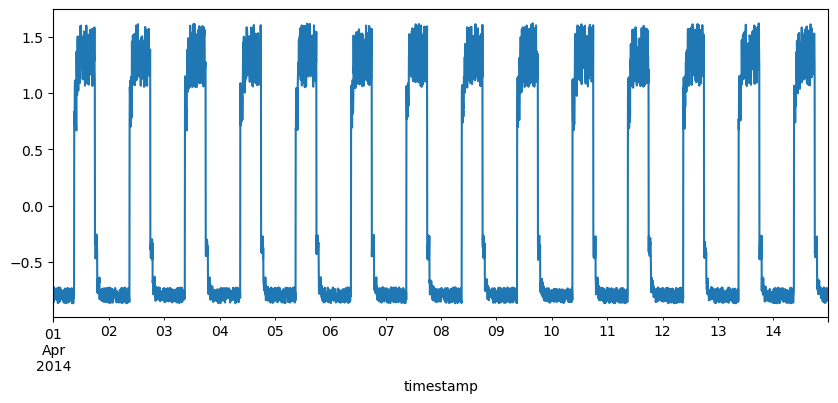

In [29]:
# 1.5 stds from mean which is zero
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame
df_train_vals.plot(legend=False, ax=ax);

Prepare training data Get data values from the training timeseries data file and normalize the value data. We have a value for every 5 mins for 14 days.

24 * 60 / 5 = 288 winows per day 288 * 14 = 4032 data points in total

In [30]:
# print number of training values
df_train_vals.shape

(4032, 1)

In [31]:

#we're going to slide this across the 4032 values
#because one window is one day with 288 samples.
window_size = 288

Window example:
Explains how the window works

```python
[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
window_size = 3
[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
...
```

In [32]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
eg_win_size = 3
# Length of L.
#len(L)

In [33]:
# Number of windows from L.
len(L) - (eg_win_size - 1)

10

In [34]:
# Remove brackets.
len(L) - eg_win_size + 1

10

In [35]:
# Print the windows.
for i in range(len(L) - eg_win_size + 1):
    print(L[i:i + eg_win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [36]:
# For accumulating the windows.
eg_wins = []

# Generate the windows
for i in range(len(L) - eg_win_size + 1):
    wins.append(L[i:i + eg_win_size])

eg_wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

In [37]:
# Create a 2D numpy array from wins.
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [82]:
# values and widow_size
#create the windows 
#create a window function to create windows array based on 
def windows(vals, N=window_size):
  # empty array.
  L = []
  # Loop through all possible windows
  for i in range(len(vals) - N + 1): #to get same size
    # append each window to the list
    L.append(vals[i:i+N])
  # return stacked windows
  return np.stack(L)


In [85]:
# create windows for training values
x_train = windows(df_train_vals)
#
x_train.shape
x_train

(3745, 288, 1)

In [40]:
# print first and last values of first widow and last value of last window
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [41]:
# rounded
#get first and last row of training values
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [92]:
# number of training examples. in 288 windows.
# 
#from 4032 we end up with 3745 examples because we stop at 3745
#or else windows will get progressively smaller after window 3745
x_train.shape
#print(x_train)

(3745, 288, 1)

In [91]:
#
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

In [44]:
# now flatter the array into a 1 d array of 3745 values
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

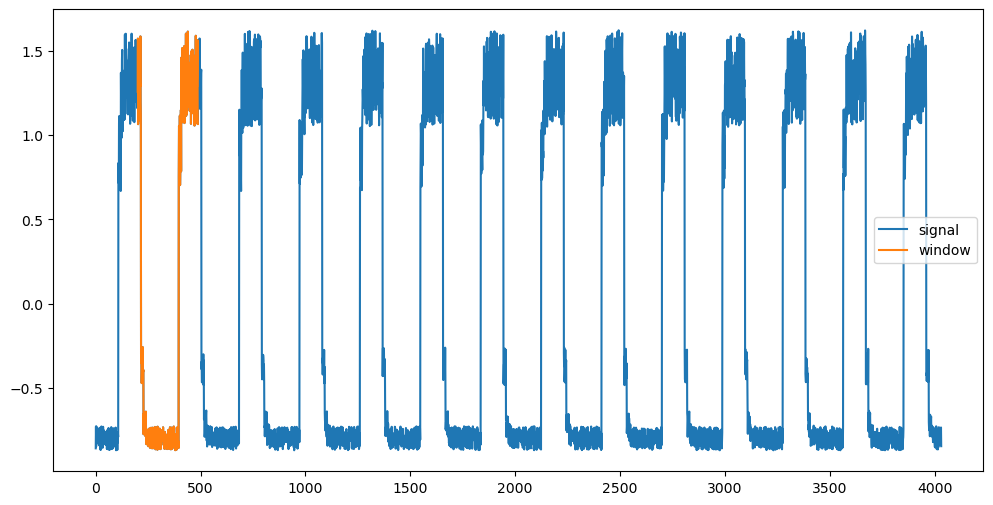

In [45]:
# We can now identify an indvitual window
window_no = 200

# create a plt plot
fig, ax = plt.subplots(figsize=(12, 6))

# plot the training values
y = df_train_vals['value'].values

# x axis is the shape of the array (time series of 4032 samples)
#  label the training values visualisation, signal
# y axis is the training values
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The first window.
# Window 200 must have been somewhere towards the end of 1st day (200 < 288) and 24 hourse or 288 * 5min intervals into the next day.
#flatten into 1 d array of 288
w = x_train[window_no].flatten()

# 
#plot on x axis of main plot with training values.
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend();

So what happened?
We can now visualise any window of a data sample onto our training data, although the example above is a window from the training dataset.

## Neural Network

***

In [46]:
x_train.shape

(3745, 288, 1)

In [78]:
# from model sequential cell in other notbook
#create layers of?
#explain each layer
layers = [
  #https://keras.io/api/layers/core_layers/input/
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  #
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [79]:
# the model bit from above
model = keras.Sequential(layers)

In [80]:
# set optimzier
#what is adam
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [81]:
# apply 
#whats is mse
model.compile(optimizer=optimizer, loss="mse")

In [51]:
model.summary()
#all the differnt layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [52]:
# model .fit https://keras.io/api/models/model_training_apis/
#returns a history object - dictionary?
#find a link to the history
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
#search keras model fit....find fit method in sequential class
history = model.fit(
    #trains model oninput and output
    #no anomally ones
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 4s 39ms/step - loss: 0.5522 - val_loss: 0.2227
Epoch 2/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0965 - val_loss: 0.0496
Epoch 3/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0566 - val_loss: 0.0357
Epoch 4/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0468 - val_loss: 0.0297
Epoch 5/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0402 - val_loss: 0.0272
Epoch 6/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0357 - val_loss: 0.0246
Epoch 7/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0321 - val_loss: 0.0221
Epoch 8/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0295 - val_loss: 0.0215
Epoch 9/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0271 - val_loss: 0.0207
Epoch 10/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0250 - val_loss: 0.0215
Epoch 11/

## Evaluation

***

In [53]:
history.history["loss"]

[0.5521597266197205,
 0.09653071314096451,
 0.056560318917036057,
 0.04682216793298721,
 0.04022437334060669,
 0.03567079082131386,
 0.032132986932992935,
 0.029509106650948524,
 0.027116406708955765,
 0.025020672008395195,
 0.023347068578004837,
 0.021948719397187233,
 0.02060426026582718,
 0.019531937316060066,
 0.018585965037345886,
 0.017806384712457657,
 0.01702873408794403,
 0.01629122905433178,
 0.01572904922068119,
 0.015160075388848782,
 0.014621552079916]

In [54]:
history.history["val_loss"]

[0.22272446751594543,
 0.04961353540420532,
 0.035689372569322586,
 0.02972077764570713,
 0.027185628190636635,
 0.024558236822485924,
 0.02212982252240181,
 0.021490314975380898,
 0.020737284794449806,
 0.021486220881342888,
 0.018675392493605614,
 0.019951697438955307,
 0.018547184765338898,
 0.017317727208137512,
 0.01630770042538643,
 0.015528080053627491,
 0.016280263662338257,
 0.018429525196552277,
 0.016944635659456253,
 0.01681799814105034,
 0.017645854502916336]

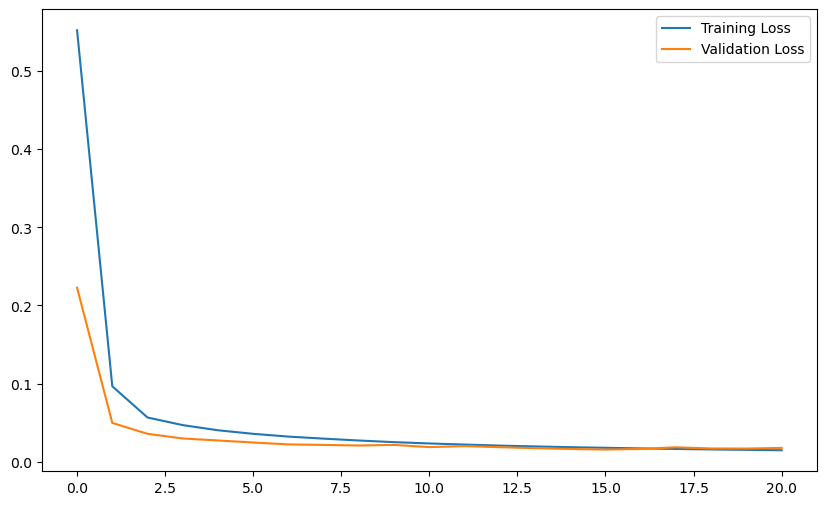

In [55]:
#history is fitted model
#loss is trainingloss
#val las is validation loss
#
fig, ax = plt.subplots(figsize = (10,6))
#
ax.plot(history.history["loss"], label="Training Loss")
#
ax.plot(history.history["val_loss"], label="Validation Loss")
#
ax.legend()

In [56]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
#get model just trained to predict the values out of the training

118/118 [==============================] - 1s 4ms/step


In [57]:
# Calculate loss...
#take mean, absolute value of the xtrain predciton minus xtrain on axis 1
#work how accuratge are, standard way, could square it
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

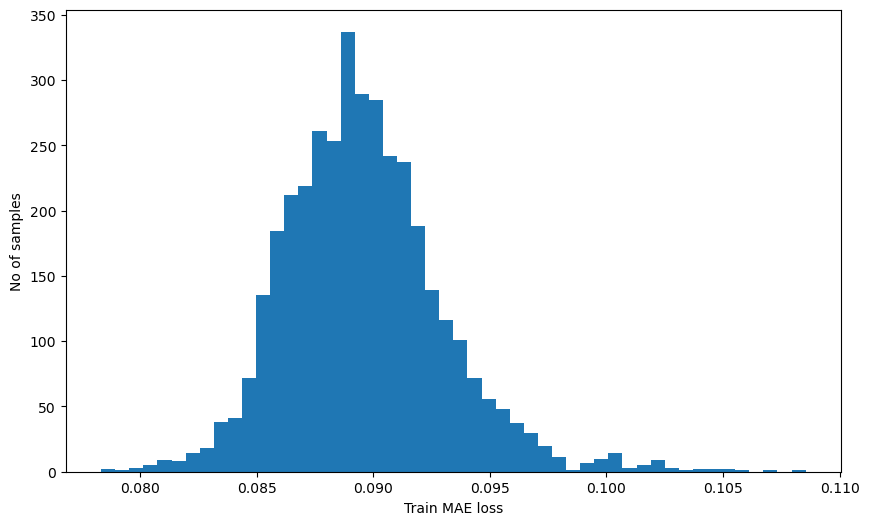

In [58]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.hist(train_mae_loss, bins=50)
# 
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [59]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# 
threshold

0.10854640711388848

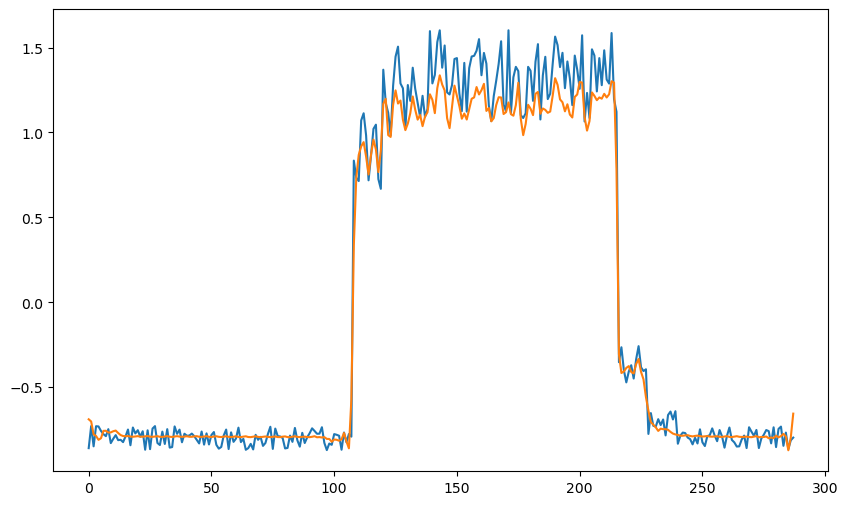

In [60]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
ax.plot(x_train[0])

# 
ax.plot(x_train_pred[0]);

In [61]:
# train mean and std from above
#subtracking training mean from training std
#df daily jupsup
#what ever happens to training value also happens to data values
df_test_value = (df_daily_jumpsup - train_mean) / train_std

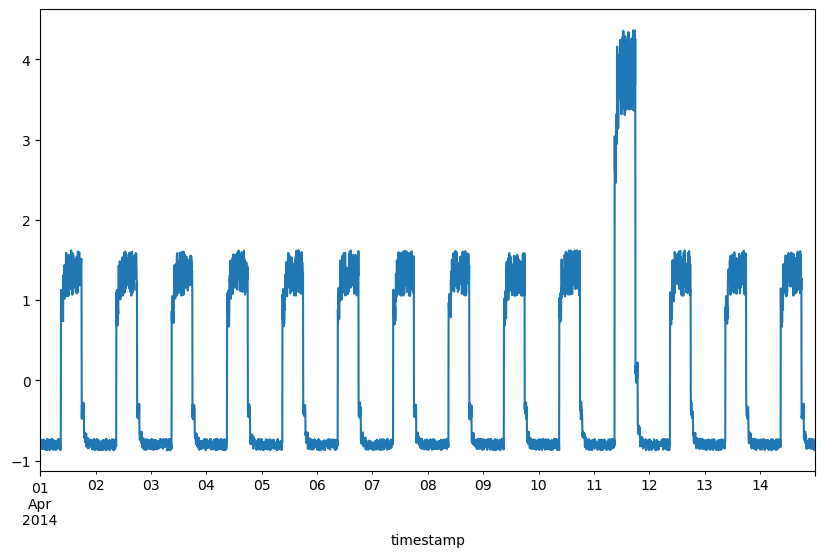

In [62]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_test_value.plot(legend=False, ax=ax);

In [63]:
# Create sequences from test values. #create windows
x_test = windows(df_test_value.values)

x_test.shape

(3745, 288, 1)

In [64]:
# 
x_test_pred = model.predict(x_test)

118/118 [==============================] - 1s 5ms/step


In [65]:
# google test_mae_loss
#
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.08560657],
       [0.08589181],
       [0.08935824],
       ...,
       [0.09248327],
       [0.09436249],
       [0.09079812]])

In [66]:
# 
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.08560657, 0.08589181, 0.08935824, ..., 0.09248327, 0.09436249,
       0.09079812])

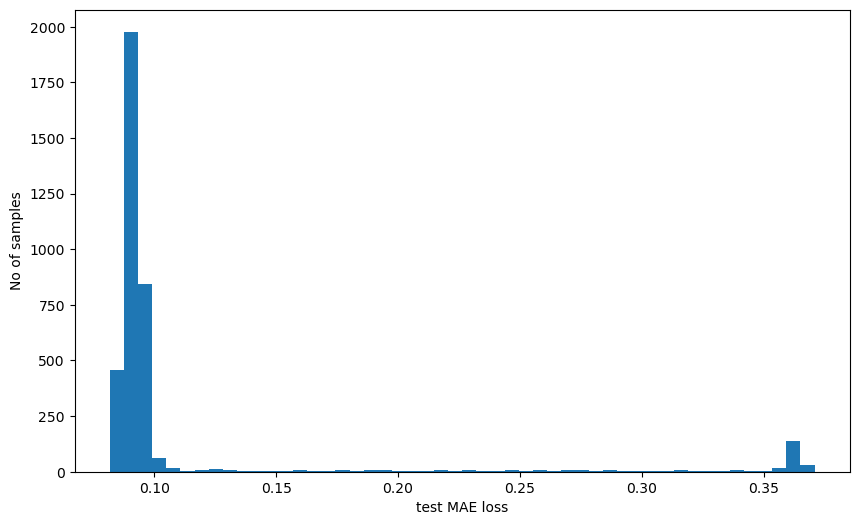

In [67]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

#
ax.hist(test_mae_loss, bins=50)

# 
ax.set_xlabel("test MAE loss")

# 
ax.set_ylabel("No of samples");

In [68]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# Number of anomalies.
np.sum(anomalies)

394

In [69]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
#anomolous data indicies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [70]:
# add anomalies to df
df_subset = df_daily_jumpsup.iloc[inds]

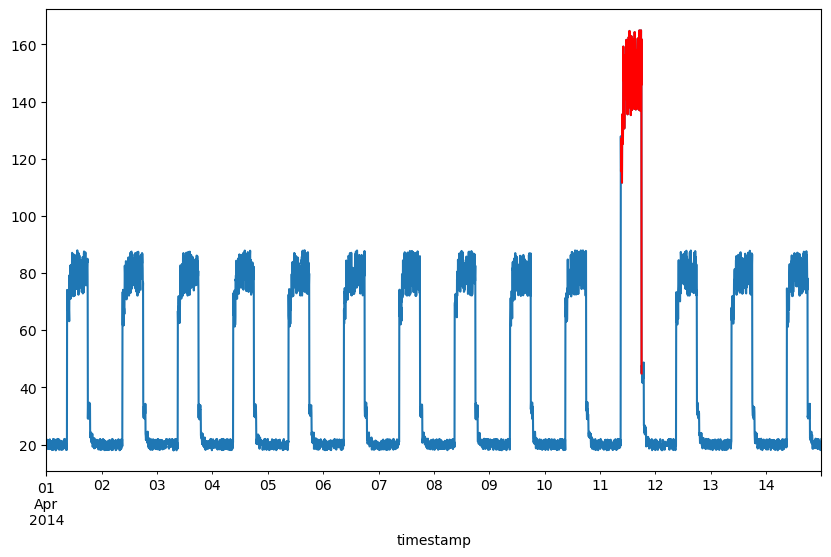

In [71]:
#
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_daily_jumpsup.plot(legend=False, ax=ax)

# anomalies
df_subset.plot(legend=False, ax=ax, color="r");

***
References
Demystifying Numenta anomaly benchmark

Singh, N. and Olinsky, C. (2017). Demystifying Numenta anomaly benchmark. [online] IEEE Xplore. doi:10.1109/IJCNN.2017.7966038.


(Singh and Olinsky, 2017)

## End